<a href="https://colab.research.google.com/github/valentinaechavarria/project_web-traffic-forecasting/blob/develop/01%20-%20entrega%20final%20completo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Necessary Imports for the project - Run this FIRST

A continuacion importamos las librerias necesarias para trabajar con los datos.

In [3]:
!pip install pystan~=2.14
!pip install fbprophet
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Creamos las credenciales para poder descargar los datos de Kaggle. 

In [4]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"valenporras","key":"28c7daeed61b141d06c5a3f1035b0107"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
%%bash
export KAGGLE_CONFIG_DIR=~/.kaggle/
kaggle competitions download web-traffic-time-series-forecasting -f key_1.csv.zip
kaggle competitions download web-traffic-time-series-forecasting -f key_2.csv.zip
kaggle competitions download web-traffic-time-series-forecasting -f sample_submission_1.csv.zip
kaggle competitions download web-traffic-time-series-forecasting -f sample_submission_2.csv.zip
kaggle competitions download web-traffic-time-series-forecasting -f train_1.csv.zip
kaggle competitions download web-traffic-time-series-forecasting -f train_2.csv.zip

100%|██████████| 96.0M/96.0M [00:03<00:00, 30.4MB/s]
100%|██████████| 101M/101M [00:03<00:00, 31.0MB/s]
100%|██████████| 66.0M/66.0M [00:02<00:00, 28.6MB/s]
100%|██████████| 68.2M/68.2M [00:02<00:00, 28.8MB/s]
100%|██████████| 102M/102M [00:03<00:00, 31.1MB/s] 
100%|██████████| 150M/150M [00:04<00:00, 33.8MB/s]


Aca podemos evidenciar que los datos estan cargados y descomprimidos correctamente

In [6]:
cd /content

/content


In [7]:
!unzip -o key_1.csv.zip
!unzip -o key_2.csv.zip
!unzip -o sample_submission_1.csv.zip
!unzip -o sample_submission_2.csv.zip
!unzip -o train_1.csv.zip
!unzip -o train_2.csv.zip

Archive:  key_1.csv.zip
  inflating: key_1.csv               
Archive:  key_2.csv.zip
  inflating: key_2.csv               
Archive:  sample_submission_1.csv.zip
  inflating: sample_submission_1.csv  
Archive:  sample_submission_2.csv.zip
  inflating: sample_submission_2.csv  
Archive:  train_1.csv.zip
  inflating: train_1.csv             
Archive:  train_2.csv.zip
  inflating: train_2.csv             


In [8]:
ls

key_1.csv      sample_submission_1.csv      train_1.csv.zip
key_1.csv.zip  sample_submission_1.csv.zip  train_2.csv
key_2.csv      sample_submission_2.csv*     train_2.csv.zip
key_2.csv.zip  sample_submission_2.csv.zip
sample_data/   train_1.csv


# 1. Importing and Analyzing Data - Initial Approach

Con base a los requerimientos del reto planteado en Kaggle llamado Web Traffic Time Series Forecasting , el objetivo de este es implementar un modelo que nos permita realizar un pronóstico y predicción de tráfico web basado en series temporales; en este caso, del tráfico web de artículos de Wikipedia. 


In [9]:
import numpy as np
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
import math as math

%matplotlib inline

train = pd.read_csv("/content/train_1.csv")
keys = pd.read_csv("/content/key_1.csv")
ss = pd.read_csv("/content/sample_submission_1.csv")

In [10]:
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


### Null Values

Hay datos que estan Null, si examinamos la longitud de los archivos de entrenamiento, resulta que son 145063 filas, y cuando vemos lo que se debe predecir, son 62 días, esto nos lleva a inferir que no todas las paginas tienen visitas todos los dias por que la longitud de los archivos no coincide (Deberian ser 8993906).

Esto significa que cada página debe indicar su predicción para cada uno de los 62 días y  los 145063 son series temporales individuales para cada página visitada

In [11]:
print("Total NaN Values: ", train.shape[0])
nan_values = train[train.isnull().any(axis=1)]
print("Total Records that are NaN: ", nan_values.shape[0])
nan_values.iloc[np.r_[0:10, len(nan_values)-10:len(nan_values)]]

Total NaN Values:  145063
Total Records that are NaN:  27786


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0
6,91Days_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,7.0,33.0,8.0,11.0,4.0,15.0,6.0,8.0,6.0
10,ASTRO_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,11.0,38.0,85.0,79.0,30.0,14.0,10.0,38.0,12.0,51.0
13,AlphaGo_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.0,13.0,14.0,17.0,19.0,56.0,21.0,13.0,21.0,11.0
19,B-PROJECT_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,26.0,10.0,5.0,5.0,11.0,10.0,4.0,8.0,6.0
24,BLACK_PINK_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32.0,56.0,39.0,65.0,78.0,143.0,96.0,63.0,28.0,75.0
27,Beautiful_Mind_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.0,8.0,6.0,7.0,2.0,11.0,11.0,29.0,12.0,14.0
37,Dear_My_Friends_zh.wikipedia.org_all-access_sp...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,12.0,8.0,12.0,3.0,10.0,21.0,6.0,8.0,9.0
38,Doctors_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,19.0,175.0,17.0,21.0,30.0,65.0,70.0,18.0,68.0
48,Fantastic_Duo_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,16.0,15.0,11.0,10.0,7.0,12.0,9.0,8.0,10.0


### Visualizing the Data

A continuacion mostramos algunas series temporales por pagiona, en las cuales se pueden evidenciar los datos faltantes que hay fechas en las cuales no hay visitas. 

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32043 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 33394 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22823 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31291 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22485 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23567 missing from current font.
  font.set_

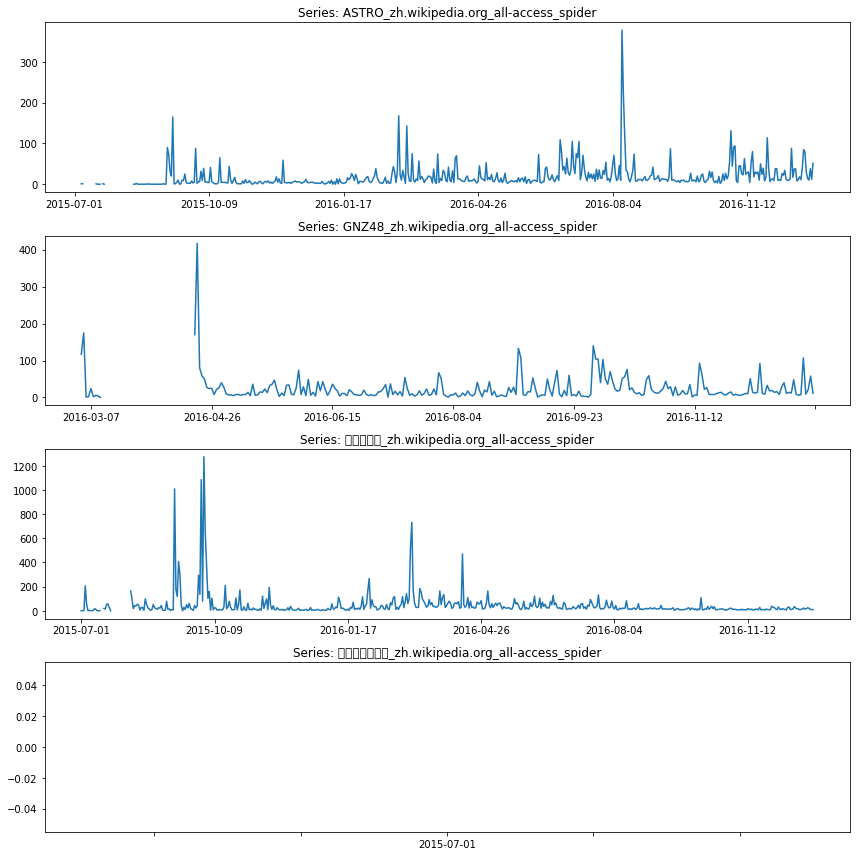

In [12]:
def plot_time_series(df, row_num, start_col =1, ax=None):
    if ax is None:
            fig = plt.figure(facecolor='w', figsize=(10, 12))
            ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
        
    series_title = df.iloc[row_num, 0]
    sample_series = df.iloc[row_num, start_col:]
    sample_series.plot(ax=ax)
    ax.set_title("Series: %s" % series_title)

fig, axs  = plt.subplots(4,1,figsize=(12,12))
plot_time_series(nan_values, 2, ax=axs[0])
plot_time_series(nan_values, 15, ax=axs[1])
plot_time_series(nan_values, 100, ax=axs[2])
plot_time_series(nan_values, 1005, ax=axs[3])

plt.tight_layout()


Existen paginas que nisiquieran tienen visitas en lo absoluto

In [13]:
nan_values.iloc[1000:1010]


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
4295,李宏毅_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4296,迪玛希·库达依别列根_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4297,7日羅曼史_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4298,漫漫回家路_(2016年電影)_zh.wikipedia.org_all-access_sp...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4299,為了與你相遇_(電影)_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4300,小林家的龍女僕_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4301,曹晏豪_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4302,徐鈞浩_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4303,生化危機7_惡靈古堡_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4304,A_LIFE～深愛的人～_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Classifying Data Fields

Como se mencionno en una entrega anterior, el campo que representa la pagina en realidad contiene varios datos diferentes que podemos usar para representar mejor la informacion y hacer distintos analisis

Los datos que se pueden extraer a continuacion son:

Idioma, Topic, Acceso y Tipo


In [14]:
import re

def split_page_attributes(str):
    fields = re.search('(.*)\_(.*).wikipedia.org\_(.*)\_(.*)', str)
    if fields is not None:
        return fields.group(1), fields.group(2), fields.group(3), fields.group(4)
    else:
        return "", "", "", ""


print(split_page_attributes("91Days_zh.wikipedia.org_all-access_spider"))
print(split_page_attributes("Resident_Evil:_Capítulo_Final_es.wikipedia.org_all-access_spider"))

('91Days', 'zh', 'all-access', 'spider')
('Resident_Evil:_Capítulo_Final', 'es', 'all-access', 'spider')


Hacemos el siguiente analisis por tipo de pagina

In [15]:
page_attributes = train.Page.str.extract(r'(?P<topic>.*)\_(?P<lang>.*).wikipedia.org\_(?P<access>.*)\_(?P<type>.*)')
page_attributes[0:10]

,topic,lang,access,type
0,2NE1,zh,all-access,spider
1,2PM,zh,all-access,spider
2,3C,zh,all-access,spider
3,4minute,zh,all-access,spider
4,52_Hz_I_Love_You,zh,all-access,spider
5,5566,zh,all-access,spider
6,91Days,zh,all-access,spider
7,A'N'D,zh,all-access,spider
8,AKB48,zh,all-access,spider
9,ASCII,zh,all-access,spider


Hay 7 idiomas más las páginas de medios. Los idiomas utilizados aquí son: inglés, japonés, alemán, francés, chino, ruso y español. Esto podria dificultar un poco cualquier análisis de las URL, ya que hay que trabajar con cuatro sistemas de escritura diferentes (latín, cirílico, chino y japonés)

Adicional, al parecer las visitas han sido accedidas desde 2 origenes y 2 tipos de agentes 

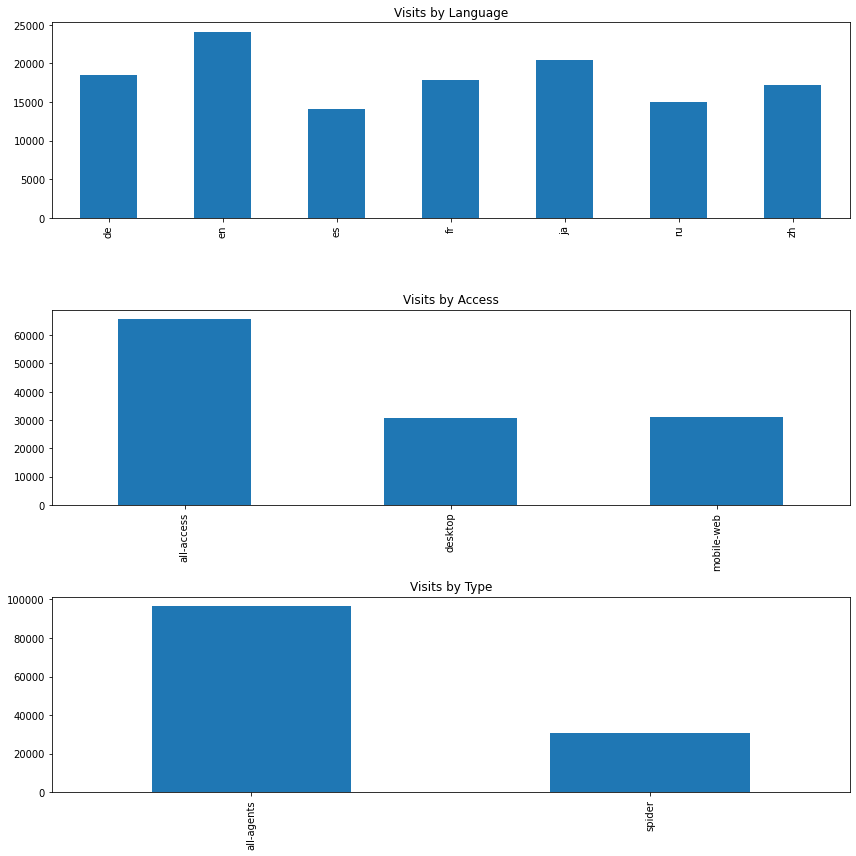

In [16]:
fig, axs  = plt.subplots(3,1,figsize=(12,12))

page_attributes["lang"].value_counts().sort_index().plot.bar(ax=axs[0])
axs[0].set_title('Visits by Language')

page_attributes["access"].value_counts().sort_index().plot.bar(ax=axs[1])
axs[1].set_title('Visits by Access')

page_attributes["type"].value_counts().sort_index().plot.bar(ax=axs[2])
axs[2].set_title('Visits by Type')

plt.tight_layout()

#2. Generating Training and Validation Data



In [17]:
concatenated_df = pd.concat([page_attributes, train], axis=1)
def get_train_validate_set(train_df, test_percent):
    train_end = math.floor((train_df.shape[1]-5) * (1-test_percent))
    train_ds = train_df.iloc[:, np.r_[0,1,2,3,4,5:train_end]]
    test_ds = train_df.iloc[:, np.r_[0,1,2,3,4,train_end:train_df.shape[1]]]
    
    return train_ds, test_ds

X_train, y_train = get_train_validate_set(concatenated_df, 0.1)

In [18]:
print("Training Data Frame with separated datafield:")
X_train.head()

Training Data Frame with separated datafield:


,topic,lang,access,type,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,...,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31,2016-11-01
0,2NE1,zh,all-access,spider,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,...,26.0,25.0,16.0,19.0,20.0,12.0,19.0,50.0,16.0,30.0
1,2PM,zh,all-access,spider,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,...,25.0,19.0,15.0,21.0,21.0,27.0,33.0,15.0,24.0,13.0
2,3C,zh,all-access,spider,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,...,6.0,5.0,5.0,2.0,3.0,3.0,2.0,2.0,6.0,1.0
3,4minute,zh,all-access,spider,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,...,9.0,13.0,21.0,13.0,10.0,21.0,15.0,103.0,22.0,15.0
4,52_Hz_I_Love_You,zh,all-access,spider,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,...,6.0,6.0,4.0,173.0,5.0,10.0,10.0,18.0,20.0,11.0


In [19]:
print("Validation sample:")
y_train.head()

Validation sample:


,topic,lang,access,type,Page,2016-11-02,2016-11-03,2016-11-04,2016-11-05,2016-11-06,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1,zh,all-access,spider,2NE1_zh.wikipedia.org_all-access_spider,18.0,25.0,14.0,20.0,8.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM,zh,all-access,spider,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,26.0,11.0,21.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C,zh,all-access,spider,3C_zh.wikipedia.org_all-access_spider,3.0,3.0,3.0,2.0,10.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute,zh,all-access,spider,4minute_zh.wikipedia.org_all-access_spider,12.0,11.0,15.0,7.0,12.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You,zh,all-access,spider,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,5.0,6.0,33.0,13.0,10.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


#3. SMAPE Algorithm

Referencia: https://www.geeksforgeeks.org/how-to-calculate-smape-in-python/



In [20]:
def smape_weirdness_fix(prediction_df, actual_df):
    actual_df = actual_df.fillna(0)
    prediction_df = prediction_df.fillna(0)

    denominator = (np.abs(actual_df) + np.abs(prediction_df)) / 2.0
    diff = np.abs(actual_df - prediction_df) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

# create testing series
testing_series_1 = X_train.iloc[0, 5:494]
testing_series_2 = X_train.iloc[0, 5:494].shift(-1)
testing_series_3 = X_train.iloc[1, 5:494]
testing_series_4 = pd.Series([0,0,0,0])

In [21]:
random_series_1 = pd.Series(np.repeat(3, 500))
random_series_2 = pd.Series(np.random.normal(3, 1, 500))
random_series_3 = pd.Series(np.random.normal(500, 20, 500))
random_series_4 = pd.Series(np.repeat(500, 500))

# testing 1 same series
print("\nSMAPE score to predict a constant array of 3")
print("Score (same series): %.3f" % smape_weirdness_fix(random_series_1, random_series_1))
print("Score (same series - 1) %.3f" % smape_weirdness_fix(random_series_1, random_series_1-1))
print("Score (same series + 1) %.3f" % smape_weirdness_fix(random_series_1, random_series_1+1))

# testing 2 same series shift by one
print("\nSMAPE score to predict a array of normal distribution around 3")
print("Score (random vs mean) %.3f" % smape_weirdness_fix(random_series_2, random_series_1))
print("Score (random vs mean-1) %.3f" % smape_weirdness_fix(random_series_2, random_series_2-1))
print("Score (random vs mean+1) %.3f" % smape_weirdness_fix(random_series_2, random_series_2+1))
print("Score (random vs mean*0.9) %.3f" % smape_weirdness_fix(random_series_2, random_series_2*0.9))
print("Score (random vs mean*1.1) %.3f" % smape_weirdness_fix(random_series_2, random_series_2*1.1))

# testing 3 totally different series
print("\nSMAPE score to predict a array of normal distribution around 500")
print("Score (random vs mean) %.3f" % smape_weirdness_fix(random_series_3, random_series_4))
print("Score (random vs mean-20) %.3f" % smape_weirdness_fix(random_series_3, random_series_3-20))
print("Score (random vs mean+20) %.3f" % smape_weirdness_fix(random_series_3, random_series_3+20))
print("Score (random vs mean*0.9) %.3f" % smape_weirdness_fix(random_series_3, random_series_3*0.9))
print("Score (random vs mean*1.1) %.3f" % smape_weirdness_fix(random_series_3, random_series_3*1.1))


SMAPE score to predict a constant array of 3
Score (same series): 0.000
Score (same series - 1) 0.400
Score (same series + 1) 0.286

SMAPE score to predict a array of normal distribution around 3
Score (random vs mean) 0.286
Score (random vs mean-1) 0.514
Score (random vs mean+1) 0.325
Score (random vs mean*0.9) 0.105
Score (random vs mean*1.1) 0.095

SMAPE score to predict a array of normal distribution around 500
Score (random vs mean) 0.034
Score (random vs mean-20) 0.041
Score (random vs mean+20) 0.039
Score (random vs mean*0.9) 0.105
Score (random vs mean*1.1) 0.095


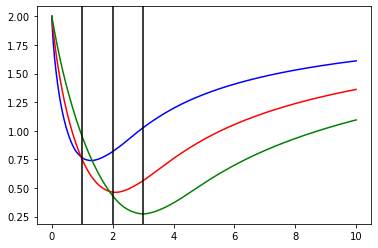

In [22]:
y_true_1 = pd.Series(np.random.normal(1, 1, 500))
y_true_2 = pd.Series(np.random.normal(2, 1, 500))
y_true_3 = pd.Series(np.random.normal(3, 1, 500))
y_pred = pd.Series(np.ones(500))
x = np.linspace(0,10,1000)
res_1 = list([smape_weirdness_fix(y_true_1, i * y_pred) for i in x])
res_2 = list([smape_weirdness_fix(y_true_2, i * y_pred) for i in x])
res_3 = list([smape_weirdness_fix(y_true_3, i * y_pred) for i in x])
plt.plot(x, res_1, color='b')
plt.plot(x, res_2, color='r')
plt.plot(x, res_3, color='g')
plt.axvline(x=1, color='k')
plt.axvline(x=2, color='k')
plt.axvline(x=3, color='k')

#4. Prediction Models

In [23]:
def series_sample_extractor(df, row_num, start_idx):
    y = df.iloc[row_num, start_idx:]
    df = pd.DataFrame({ 'ds': y.index, 'y': y.values})
    return df

def plot_prediction_and_actual(train, forecast, actual, xlim=None, ylim=None, figSize=None, title=None):
    fig, ax  = plt.subplots(1,1,figsize=figSize)
    ax.plot(pd.to_datetime(train.index), train.values, 'k.')
    ax.plot(pd.to_datetime(actual.index), actual.values, 'r.')
    ax.plot(pd.to_datetime(forecast.index), forecast.values, 'b-')
    ax.set_title(title)
    plt.show()    

In [24]:
sample_df_train = series_sample_extractor(X_train, 2, 5)
sample_df_train.head()

,ds,y
0,2015-07-01,1.0
1,2015-07-02,0.0
2,2015-07-03,1.0
3,2015-07-04,1.0
4,2015-07-05,0.0


In [25]:
sample_df_actual = series_sample_extractor(y_train, 2, 5)
sample_df_actual.head()

,ds,y
0,2016-11-02,3.0
1,2016-11-03,3.0
2,2016-11-04,3.0
3,2016-11-05,2.0
4,2016-11-06,10.0


### Median Model

In [26]:
def nanmedian_zero(a):
    return np.nan_to_num(np.nanmedian(a))

def median_model(df_train, df_actual, p, review=False, figSize=(12, 4)):
    df_train = df_train.fillna(0)
    df_actual = df_actual.fillna(0)
    visits = nanmedian_zero(df_train['y'].values[-p:])
    train_series = df_train['y']
    train_series.index = df_train.ds
    
    idx = np.arange( p) + np.arange(len(df_train)- p+1)[:,None]
    b = [row[row>=0] for row in df_train.y.values[idx]]
    pre_forecast = pd.Series(np.append(([float('nan')] * (p-1)), list(map(nanmedian_zero,b))))
    pre_forecast.index = df_train.ds
    
    forecast_series = pd.Series(np.repeat(visits, len(df_actual)))
    forecast_series.index = df_actual.ds
    
    forecast_series = pre_forecast.append(forecast_series)
    
    actual_series = df_actual.y
    actual_series.index = df_actual.ds
    
    if(review):
        plot_prediction_and_actual(train_series, forecast_series, actual_series, figSize=figSize, title='Median model')
    
    return smape_weirdness_fix(forecast_series, actual_series)   

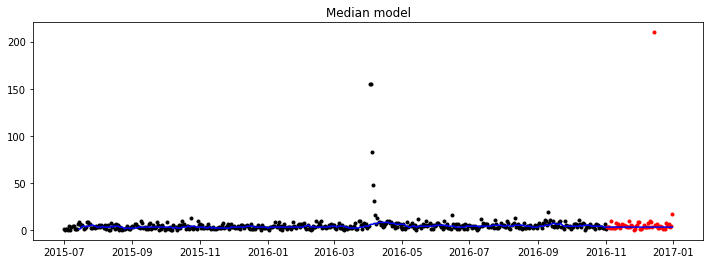

The SMAPE score is : 0.50096


In [27]:
score = median_model(sample_df_train.copy(), sample_df_actual.copy(), 15, review=True)
print("The SMAPE score is : %.5f" % score)

### ARIMA Model

In [28]:
from statsmodels.tsa.arima_model import ARIMA   
import warnings

def arima_model(df_train, df_actual, p, d, q, figSize=(12, 4), review=False):
    df_train = df_train.fillna(0)
    train_series = df_train.y
    train_series.index = df_train.ds

    result = None
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        try:
            arima = ARIMA(train_series ,[p, d, q])
            result = arima.fit(disp=False)
        except Exception as e:
            print('\tARIMA failed', e)
                
    start_idx = df_train.ds[d]
    end_idx = df_actual.ds.max()
    forecast_series = result.predict(start_idx, end_idx,typ='levels')
    
    actual_series = df_actual.y
    actual_series.index = pd.to_datetime(df_actual.ds)

    if(review):
        plot_prediction_and_actual(train_series, forecast_series, actual_series, figSize=figSize, title='ARIMA model')
    
    return smape_weirdness_fix(forecast_series, actual_series)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


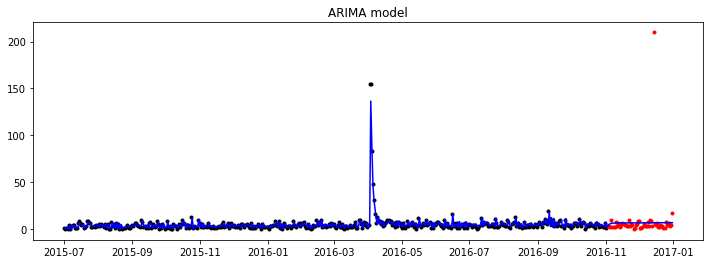

The SMAPE score is : 0.65757


In [29]:
score = arima_model(sample_df_train.copy(), sample_df_actual.copy(), 2, 1, 2, review=True)
print("The SMAPE score is : %.5f" % score)

# 5. Comparisons

A continuacion comparamos los 2 modelos, escogiendo diferentes time series 

#### Validation

In [30]:
def get_better_smape(median_model_score, arima_model_score):
  if median_model_score < arima_model_score:
    result = arima_model_score - median_model_score
    print("The MEDIAN model is better by less than: %.5f" % result)
  elif median_model_score > arima_model_score:
    result = median_model_score - arima_model_score
    print("The ARIMA model is better by less than: %.5f" % result)
  else:
    print("Both results match")  


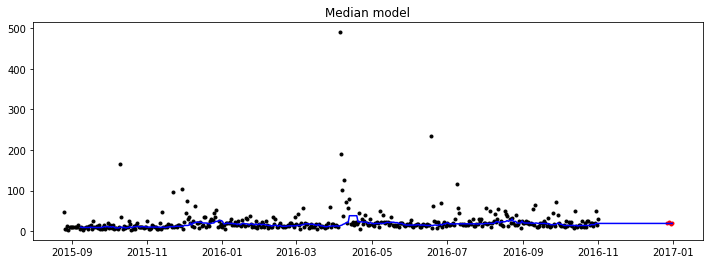

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


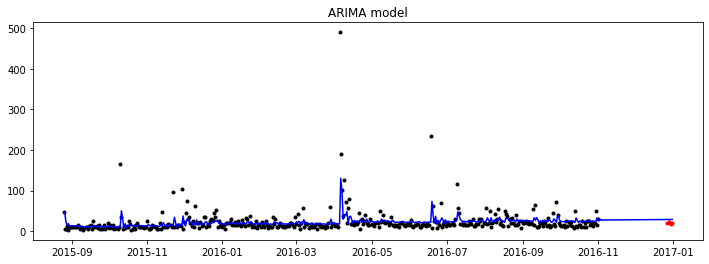

The SMAPE score for MEDIAN is : 0.06059
The SMAPE score for ARIMA is : 0.36815
The MEDIAN model is better by less than: 0.30756


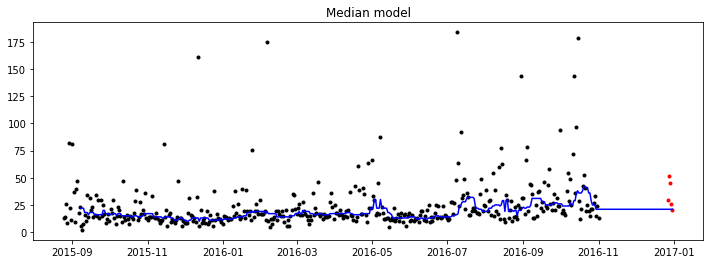

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


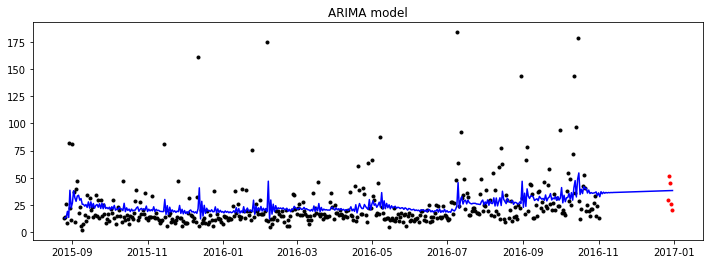

The SMAPE score for MEDIAN is : 0.43822
The SMAPE score for ARIMA is : 0.34340
The ARIMA model is better by less than: 0.09481


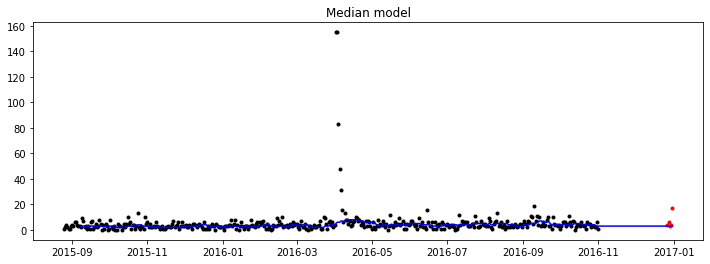

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


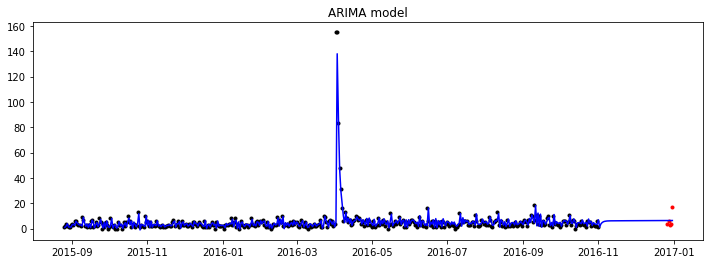

The SMAPE score for MEDIAN is : 0.52762
The SMAPE score for ARIMA is : 0.52292
The ARIMA model is better by less than: 0.00470


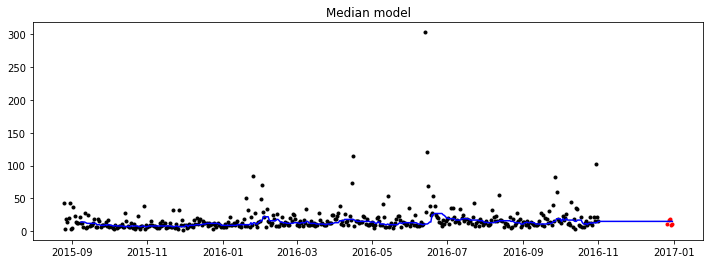

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


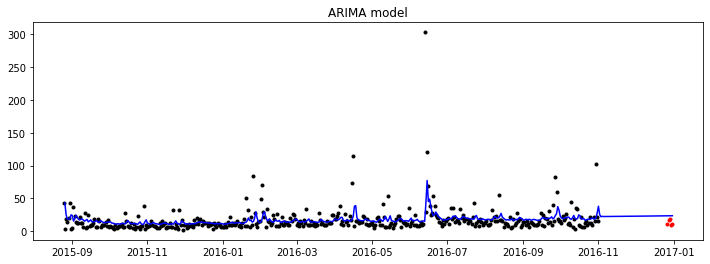

The SMAPE score for MEDIAN is : 0.27514
The SMAPE score for ARIMA is : 0.55872
The MEDIAN model is better by less than: 0.28358


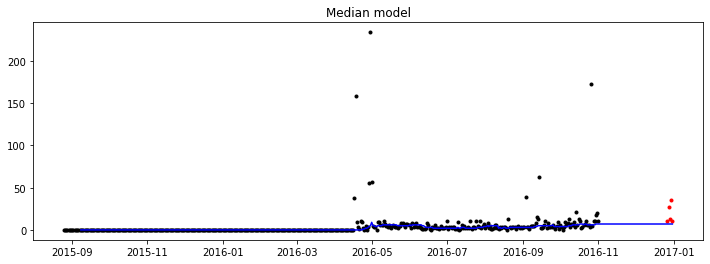

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


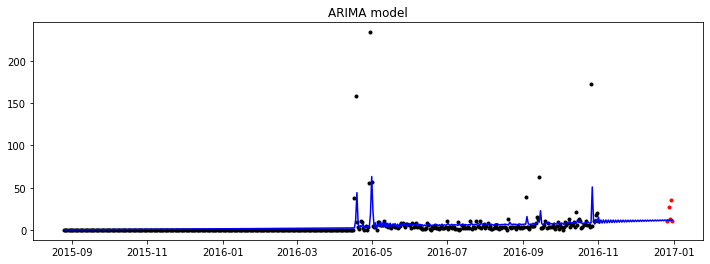

The SMAPE score for MEDIAN is : 0.78454
The SMAPE score for ARIMA is : 0.44709
The ARIMA model is better by less than: 0.33745


In [31]:
test1_df_train = series_sample_extractor(X_train, 0, 60)
test1_df_actual = series_sample_extractor(y_train, 0, 60)

score_median = median_model(test1_df_train.copy(), test1_df_actual.copy(), 15, review=True)
score_arima = arima_model(test1_df_train.copy(), test1_df_actual.copy(), 2, 1, 2, review=True)


print("The SMAPE score for MEDIAN is : %.5f" % score_median)
print("The SMAPE score for ARIMA is : %.5f" % score_arima)
get_better_smape(score_median, score_arima)

test2_df_train = series_sample_extractor(X_train, 1, 60)
test2_df_actual = series_sample_extractor(y_train, 1, 60)

score_median = median_model(test2_df_train.copy(), test2_df_actual.copy(), 15, review=True)
score_arima = arima_model(test2_df_train.copy(), test2_df_actual.copy(), 2, 1, 2, review=True)


print("The SMAPE score for MEDIAN is : %.5f" % score_median)
print("The SMAPE score for ARIMA is : %.5f" % score_arima)
get_better_smape(score_median, score_arima)

test3_df_train = series_sample_extractor(X_train, 2, 60)
test3_df_actual = series_sample_extractor(y_train, 2, 60)

score_median = median_model(test3_df_train.copy(), test3_df_actual.copy(), 15, review=True)
score_arima = arima_model(test3_df_train.copy(), test3_df_actual.copy(), 2, 1, 2, review=True)


print("The SMAPE score for MEDIAN is : %.5f" % score_median)
print("The SMAPE score for ARIMA is : %.5f" % score_arima)
get_better_smape(score_median, score_arima)

test4_df_train = series_sample_extractor(X_train, 3, 60)
test4_df_actual = series_sample_extractor(y_train, 3, 60)

score_median = median_model(test4_df_train.copy(), test4_df_actual.copy(), 15, review=True)
score_arima = arima_model(test4_df_train.copy(), test4_df_actual.copy(), 2, 1, 2, review=True)


print("The SMAPE score for MEDIAN is : %.5f" % score_median)
print("The SMAPE score for ARIMA is : %.5f" % score_arima)
get_better_smape(score_median, score_arima)

test5_df_train = series_sample_extractor(X_train, 4, 60)
test5_df_actual = series_sample_extractor(y_train, 4, 60)

score_median = median_model(test5_df_train.copy(), test5_df_actual.copy(), 15, review=True)
score_arima = arima_model(test5_df_train.copy(), test5_df_actual.copy(), 2, 1, 2, review=True)


print("The SMAPE score for MEDIAN is : %.5f" % score_median)
print("The SMAPE score for ARIMA is : %.5f" % score_arima)
get_better_smape(score_median, score_arima)